In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/custom.css">

# About the speaker & Contact

**Vadim Nelidov**: [Data Scientist, Educator and Innovator at GoDataDriven](https://godatadriven.com/team/vadim-nelidov/)

Feel free to contact me via

*email*: vadimnelidov@godatadriven.com

*LinkedIn*: https://www.linkedin.com/in/vadim-nelidov-4b1921188


# Where to find the materials

Use this link to a dropbox folder :
https://gdd.li/codebr_nn_files

"*code_breakfast_DL*" contains the notebook with the slides and code

 "*requirements.txt*" and "*environment.yml*" contain the Python libraries / venv requirements 
 
 **NOTE: some blocks of code may take substantial time to run, mind that when running the full notebook**

## Inspiring Breakfast Ideas: Brain Food for Neural Network Fans!

(click on the pic)

<p></p>

<a href="https://www.aheadofthyme.com/2015/12/cinnamon-and-walnut-porridge/">
<img src="https://www.aheadofthyme.com/wp-content/uploads/2015/12/cinnamon-and-walnut-porridge-02.jpg" style="width: 600px;" href/>
 </a>
 
                                             Cinnamon and Walnut Porridge

# Vulnerabilities of Neural Networks: Find, Defend and Prevent


<img src="images/intro.png" width="650" style="display: block;margin-left: auto;margin-right: auto;"/>


![footer_logo](images/logo.png)

# Program

- Risks involved with NNs
- Adversary NN Manipulations and how they work
- Attack Types
- Building a benchmark "target" model
- Implementing various attack strategies
- Defense types
- Implementation of defenses
- Future extensions and tips

# Risks involved with NNs

- voice and face recognition manipulation
- failure of spam and fraud detection
- unnoticed computer security threats
- computer vision and autonomous machine failure
- never again getting speeding fines? 🤔

# Risks involved with NNs

<img src="images/road_sign.png" width="500" style="display: block;margin-left: auto;margin-right: auto;"/>

# Adversary NN Manipulation: idea

<img src="images/attack_logic.png" width="700" style="display: block;margin-left: auto;margin-right: auto;"/>

# Adversary NN Manipulation: strategic noise

<img src="images/strategic_noise.png" width="700" style="display: block;margin-left: auto;margin-right: auto;"/>

# Black box vs white box attacks

**White box attack**: the underlying network is *fully known* (e.g. using MobileNet) and is used to train a "noise-maker"

**Black box attack**: the underlying network is *unknown*

- passing many training samples into the network and obtaining the output
- using this labeled output to train a new NN that produces same output
- using this new inferred NN as if it was a *white box attack*

Check the [original 2015 paper](https://arxiv.org/pdf/1602.02697.pdf) about black box attacks

# Evasion attacks vs Poison attacks

**Evasion attacks**: tricking a system to identify an input as a desired / wrong class

**Poison attacks**: sabotaging the learning process of an algorithm

- manipulated of engineered mislabeled samples
- e.g. virus-like code with a non-virus label for antivirus programs
- mostly relevant for online learning
- we should be careful with what we use for training!


# Code time!

## Plan of attack

1. Train / import an accurate classification model
2. Apply a few powerful attack algorithms
3. Use generated adversarial samples to test model's vulnerability
4. Try various defensive techniques and find the most helpful
5. Combine selected techniques into the final robust model

In [191]:
#imports

#ADJUST THIS FURTHER

import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten ,Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, Reshape, Add
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.regularizers import l1_l2, l2, l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_custom_objects
from tensorflow.python.keras import backend as K
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array, ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import random

(60000, 28, 28)


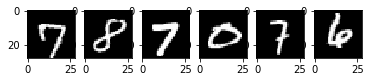

In [106]:
#loading data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)

[ax.imshow(random.choice(X_train), cmap="gray") for ax in plt.subplots(1, 6)[1]];

In [107]:
#adjusting images and encoding labels

if len(X_train.shape) != 4:
    X_train = np.expand_dims(X_train, axis=3)
if len(X_test.shape) != 4:
    X_test = np.expand_dims(X_test, axis=3)

X_train, X_test = X_train.astype("float") / 255, X_test.astype("float") / 255
y_train_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_test)

In [108]:
#checking shapes
print(
    f"Train:\tX shape:{X_train.shape}\tY shape:{y_train_onehot.shape}\tType (X, y): ({X_train.dtype}, {y_train_onehot.dtype})\tX values (min, max): ({X_train.min()}, {X_train.max()})"
)
print(
    f"Test:\tX shape:{X_test.shape}\tY shape:{y_test_onehot.shape}\tType (X, y): ({X_test.dtype}, {y_test_onehot.dtype})\tX values (min, max): ({X_test.min()}, {X_test.max()})"
)

Train:	X shape:(60000, 28, 28, 1)	Y shape:(60000, 10)	Type (X, y): (float64, float32)	X values (min, max): (0.0, 1.0)
Test:	X shape:(10000, 28, 28, 1)	Y shape:(10000, 10)	Type (X, y): (float64, float32)	X values (min, max): (0.0, 1.0)


# First we create a high-accuracy CNN 

### Here we use:

- Two convolutional layers
- Padding to better pick up edge pieces
- One fully-connected layer at the end
- Dropouts to decrease overfitting
- Softmax activation at the end as we have multi-class classification
- Early stopping callback to prevent excessive learning

## Homework

Redo our whole procedure with a state-of-art NN using Transfer learning --> they are vulnerable too!

(for example MobileNet or Inception)

In [6]:
#fix the random state for reproducibility
from tensorflow import set_random_seed
set_random_seed(2222)

In [7]:
#building the target CNN model
def make_mnist_model(name):

    inputs = Input(shape=(28, 28, 1))

    net = Conv2D(64, kernel_size=2, padding="same", activation="relu")(inputs)
    net = MaxPool2D(pool_size=2)(net)

    net = Dropout(rate = 0.3)(net)
    net = Conv2D(filters=32, kernel_size=2, padding="same", activation="relu")(net)
    net = MaxPool2D(pool_size=2)(net)

    net = Dropout(rate = 0.3)(net)
    net = Flatten()(net)
    net = Dense(256, activation="relu")(net)

    net = Dropout(rate = 0.3)(net)
    predictions = Dense(10, activation="softmax")(net)

    model = Model(inputs=inputs, outputs=predictions, name=name)

    return model


mnist_model = make_mnist_model('target_classification_model')
mnist_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxP

In [9]:
#compiling the target model
mnist_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

#training target model

#earlyStop ensures we do not train "too much"
earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

mnist_model.fit(X_train, y_train_onehot, batch_size=128, epochs=10000, verbose=0,
                validation_data=(X_test, y_test_onehot), callbacks=[earlyStop])

print(mnist_model.evaluate(X_train, y_train_onehot))
print(mnist_model.evaluate(X_test, y_test_onehot))

Instructions for updating:
Use tf.cast instead.
60000/60000 [==============================] - 4s 70us/sample - loss: 0.0063 - categorical_accuracy: 0.9984
[0.006281816430466279, 0.9984]
10000/10000 [==============================] - 1s 75us/sample - loss: 0.0248 - categorical_accuracy: 0.9924
[0.02482740342307843, 0.9924]


# Adding random noise

As the example below shows, our model is robust to just randomly added noise.

A successful intervention has to be smarter than that.

Besides this way we clearly cannot control where misclassification goes.

In [156]:
#a resusable function to print a picture and show predictions

def show_predict(img, predict = False, pred_model = None, shape = (28, 28), threshold = 0.05, show_img = True):
    
    """
    an image display function for MNIST dataset
    you can determine whether predictions are also printed from a given model
    
    > img: image to print
    > predict: whether predictions are calculated and printed
    > pred_model: keras model that will be used for predictions
    > shape: image shape, 28x28 by default
    > threshold: minimum probability with which predictions will be displayed
    > show_img: if False, does not show the image
    
    """
    if show_img:
        plt.imshow(img.reshape(shape),vmin=0., vmax=1.)
        plt.show()
    
    if predict:
        
        if pred_model == None:
            print("you did not provide a model!")
            
        else:
            prediction = pred_model.predict(img)[0]
            prediction = [(f'number {range(10)[idx]}', prediction[idx]) for idx in range(10) if prediction[idx] >= threshold]
            print(prediction)

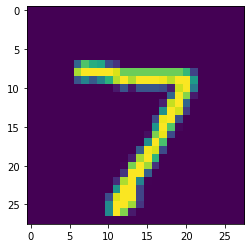

[('number 7', 0.9999968)]


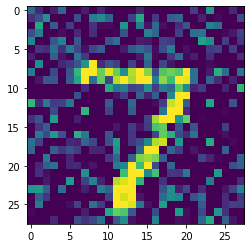

[('number 7', 0.99865663)]


In [157]:
#an adversarial example
img = X_test[0:1]
show_predict(img, predict = True, pred_model = mnist_model)

#applying random noise does not fool the classifier
quantized_noise = np.round(np.random.normal(loc=0.0, scale=0.3, size=img.shape) * 255.) / 255.
noisy_img = np.clip(img + quantized_noise, 0., 1.)
show_predict(noisy_img, predict = True, pred_model = mnist_model)

# Adversarial model training

To find "smart noise" or "minimal perturbations" that will actually manage to confuse our model, we need an **attacking algorithm**.

While there are many of such algorithms, they all follow the same idea:

*Confuse the target model while only changing the picture a bit.*

Ideally the picture is changed so marginally that neither humans nor machines can easily 'see' that something is wrong.

Practically, all algorithms differ in how *quick* vs how *effective* they are.

We will consider a few examples of such algorithms below. We will use a great new library from IBM: [adversarial-robustness-toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/index.html)

## Elastic Net Attack Method

**Idea**:

*Elastic net* is a regularized regression method that linearly combines the *L1* and *L2* penalties of the Lasso and Ridge methods

(widely used technique in solving high-dimensional feature selection problems)

#### Elastic Net Attack combines two processes:

1) trying to slightly modify the original image to move away from the most likely class to
    - either the second most likely class
    - or a given class in the case of targeted attacks
2) staying as close to the original image as possible (regularization ensures that)

As a result we usually get an image with only a few perturbations, yet misclassified

[**Original Paper**](https://arxiv.org/abs/1709.04114)

In [165]:
from art.attacks.evasion import ElasticNet
from art.classifiers import KerasClassifier

#wrapping our keras model for the attacking algorithm
wrapped_classifier = KerasClassifier(model = mnist_model, use_logits = False)


# Generating adversarial test examples
attack = ElasticNet(classifier = wrapped_classifier, targeted = False)
X_test_adv = attack.generate(x = X_test[:4])

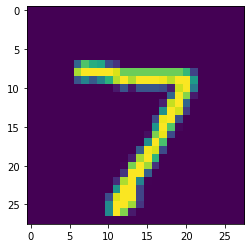

[('number 7', 0.9999968)]


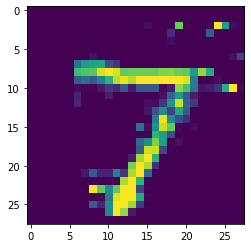

In [186]:
#plotting the original image
img = X_test[0:1]
show_predict(img, predict = True, pred_model = mnist_model)

img_adv = X_test_adv[0:1]
show_predict(img_adv, predict = False)

#uncomment to see the prediction
#show_predict(img_adv, predict = True, pred_model = mnist_model, show_img = False)

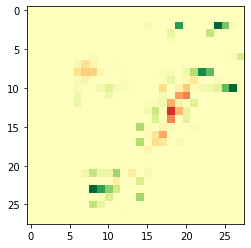

In [129]:
#here is how the changes introduced by the ElasticNet attack look like:
plt.imshow((img_adv - img).reshape((28,28)),vmin=-1., vmax=1., cmap = 'RdYlGn');

## Fast Gradient Attack Method

Likely the most popular white-box attack: it's very fast, while quite powerful and intuitive

**Idea**:

Attack neural networks by leveraging the way they learn, *gradients*

Rather than working to *minimize the loss by adjusting the weights* based on the backpropagated gradients, the attack *adjusts the input data to maximize the loss* based on the same gradients

=> the attack uses the gradient of the loss w.r.t the input data, then adjusts the input data to maximize the loss.

Based on the [pioneering paper](https://arxiv.org/abs/1412.6572) by Ian J. Goodfellow and coauthors.

In [20]:
from art.attacks.evasion import FastGradientMethod

#setting up which number we want as the result of our attack 
target_number = 9
target_vector = np.zeros(10)
target_vector[target_number] = 1.
y_test_adv = np.tile(target_vector,(len(y_test_onehot), 1))


# Generating adversarial test examples
attack2 = FastGradientMethod(classifier = wrapped_classifier, eps = 0.25, targeted = True)
X_test_adv2 = attack2.generate(x = X_test, y = y_test_adv)

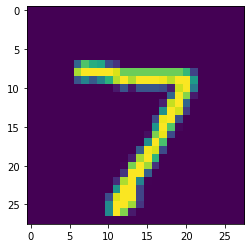

[('number 7', 0.9999968)]


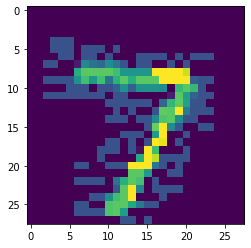

In [190]:
#plotting the original image
img = X_test[0:1]
show_predict(img, predict = True, pred_model = mnist_model)

#plotting the image modified with FastGradientMethod
img_adv2 = X_test_adv2[0:1]
show_predict(img_adv2, predict = False)

#uncomment to see the prediction
#show_predict(img_adv2, predict = True, pred_model = mnist_model, show_img = False)

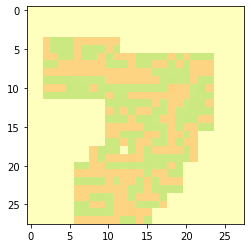

In [137]:
#here is how the changes introduced by the FastGradientMethod attack look like:
plt.imshow((img_adv2 - img).reshape((28,28)),vmin=-1., vmax=1., cmap = 'RdYlGn');

## Homework

Try other attackers from adversarial-robustness-toolbox, most notably "DeepFool" & "Carlini and Wagner L_2 Attack"

## Building a universal perturbation

**Idea**:

[A very interesting paper](http://openaccess.thecvf.com/content_cvpr_2017/papers/Moosavi-Dezfooli_Universal_Adversarial_Perturbations_CVPR_2017_paper.pdf) showed existence of universal (image-agnostic) and very small perturbation vectors that causes natural images to be misclassified with high probability in various NNs. This is one of the most striking results in the field.

The authors developed an algorithm that can compute a universal perturbation using a variety of existent attack methods.

This means that we can find a "mask" that will confused our target NN when applied to most input images

<img src="images/uap.png" width="600" style="display: block;margin-left: auto;margin-right: auto;"/>

In [59]:
# Generating adversarial test examples
from art.attacks.evasion import UniversalPerturbation

attack3 = UniversalPerturbation(classifier = wrapped_classifier, attacker = 'fgsm', eps = 0.3)
x_test_adv3 = attack3.generate(x = X_test)

art.attacks.evasion.fast_gradient.FastGradientMethod


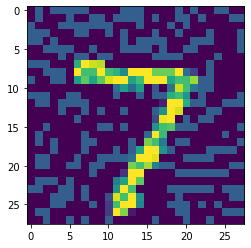

[('number 2', 0.6245198), ('number 7', 0.37546432)]


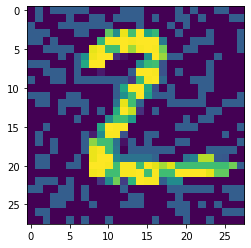

[('number 2', 0.9999995)]


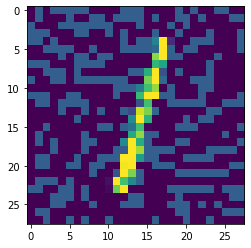

[('number 2', 0.98347753)]


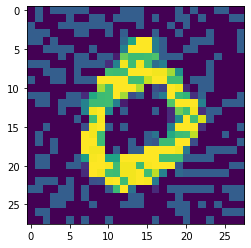

[('number 2', 0.99980587)]


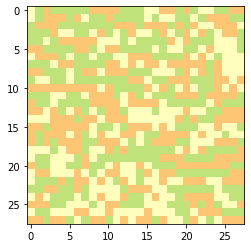

In [143]:
for i in range(4):
    
    img =  X_test[i:i+1]

    img_adv3 = x_test_adv3[i:i+1]
    show_predict(img_adv3, predict = True, pred_model = mnist_model)
    
    pertrubation = img_adv3 - img
    plt.imshow((img_adv3 - img).reshape((28,28)),vmin=-1., vmax=1., cmap = 'RdYlGn');

In [144]:
print("regular test score: ", mnist_model.evaluate(X_test, y_test_onehot))
print("adversarial test score: ", mnist_model.evaluate(x_test_adv3, y_test_onehot))

10000/10000 [==============================] - 1s 80us/sample - loss: 0.0248 - categorical_accuracy: 0.9924
regular test score:  [0.02482740342307843, 0.9924]
10000/10000 [==============================] - 1s 100us/sample - loss: 4.5157 - categorical_accuracy: 0.2845
adversarial test score:  [4.515735256195068, 0.2845]


## Let's add the 'mask' from above to create 20000 new adversarial training samples

In [145]:
X_train_adv = X_train[:20000].copy()

for i in range(len(X_train_adv)):
    X_train_adv[i] += pertrubation[0]
    
X_train_ext = np.append(X_train, X_train_adv, axis = 0)
y_train_ext = np.append(y_train_onehot, y_train_onehot[:20000].copy(), axis = 0)

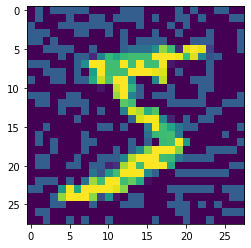

[('number 1', 0.075941525), ('number 2', 0.23704118), ('number 3', 0.4518284), ('number 5', 0.23333514)]


In [149]:
#let's check that it worked
img_adv_train = X_train_adv[0:1]
show_predict(img_adv_train, predict = True, pred_model = mnist_model)

**Great!** We've just created "new" manipulated data points. We will get back to them later.

# Defending NNs against adversarial attacks

## Possible Approaches:

- Adding input filters and / or "smart" NN layers
- [Feature squeezing](https://arxiv.org/abs/1704.01155)
- Use data augmentation and data generators during model trainings
- Include various adversarial samples into the training data
- Model training alongside an adversarial generator
- Gradient hiding (using non-differentiable models like RF)
- Mixup ([Smooth decision boundaries](https://arxiv.org/abs/1710.09412))

*Note*: none of the existing techniques guarantee 100% security. However most attack strategies can be made much less hard and effective. A combination of these defenses is usually preferable.

## input filters

Since most attacks generate small perturbations in the form of noise and "poisonous pixels", we can (hopefully) get rid of both with a little help of additional image preprocessing. Let's see some examples below

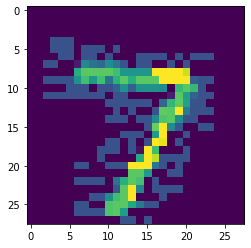

[('number 3', 0.7661993), ('number 7', 0.19242877)]


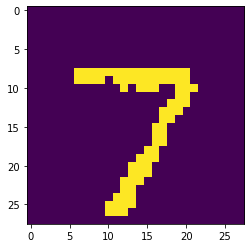

[('number 7', 0.99999213)]


In [150]:
#converting images to low precision to only keep the essence

def binary_filter_np(x):
    """
    substantially reduces image's precision.
    """
    x_bin = np.maximum(np.sign(x-0.5), 0)
    return x_bin

#show original attacked image
show_predict(img_adv2, predict = True, pred_model = mnist_model)

#show this image after filtering
img_adv2_lowpres = binary_filter_np(img_adv2)
show_predict(img_adv2_lowpres, predict = True, pred_model = mnist_model)

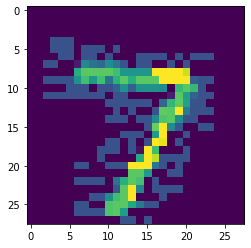

[('number 3', 0.7661993), ('number 7', 0.19242877)]


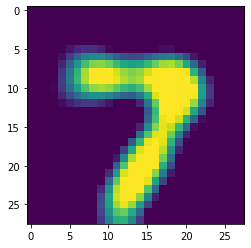

[('number 7', 0.9998492)]


In [151]:
# Sharpening with Scipy to focus on key
from scipy import misc

blurred_f = ndimage.gaussian_filter(img_adv2, 3)
filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
alpha = 70
img_adv2_sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

#show original attacked image
show_predict(img_adv2, predict = True, pred_model = mnist_model)

#show this image after sharpening
show_predict(img_adv2_sharpened, predict = True, pred_model = mnist_model)


ART library also provides a variety of preprocessing defensive tools that we can directly combine with our models. You can read more about them [here](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/preprocessor.html)

## But shouldn't convolutional filters also be able to produce similar transformations?


<img src="images/convolution_filters.png" width="500" style="display: block;margin-left: auto;margin-right: auto;"/>

## Drawbacks of preprocessing defenses

- Different filters may only work for particular attack strategies
- We are reducing image quality of normal images as well --> less information for NN --> lower accuracy
- White box attacks may still be able to find vulnerabilities in our filters as well

# Adversarial samples in training

An alternative to (manually) transforming our inputs, we can also explicitly train our NN to deal with various image perturbations. We previously created 20000 modified training examples using the flexible noise mask generated by Fast Gradient Attack Method. Now we can combine these with our initial training data and train a new model that will hopefully be flexible enough to handle both well.

In [152]:
#creating a new model that will be trained using extended training data
robust_mnist_model = make_mnist_model('robust_classification_model')

#compiling the new model
robust_mnist_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

#training the new model

earlyStop = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=3, verbose=0, mode='auto',
                          baseline=None, restore_best_weights=True)

robust_mnist_model.fit(X_train_ext, y_train_ext, batch_size=128, epochs=10000, verbose=0, validation_data=(X_test, y_test_onehot),
               callbacks=[earlyStop])

print(mnist_model.evaluate(X_train_ext, y_train_ext))
print(mnist_model.evaluate(X_test, y_test_onehot))

80000/80000 [==============================] - 7s 94us/sample - loss: 1.1730 - categorical_accuracy: 0.8187
[1.1730105533209272, 0.818725]
10000/10000 [==============================] - 1s 104us/sample - loss: 0.0248 - categorical_accuracy: 0.9924
[0.02482740342307843, 0.9924]


now we have:


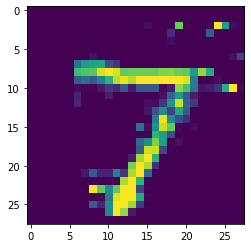

[('number 7', 0.9963773)]

with the previous model we had:
[('number 5', 0.99999)]


In [164]:
#let's check if the new model can handle adversarial examples better
#the adversarial example from elastic net
img_adv_train = X_test_adv[0:1]
print("now we have:")
show_predict(img_adv_train, predict = True, pred_model = robust_mnist_model)

print("")
print("with the previous model we had:")
show_predict(img_adv_train, predict = True, pred_model = mnist_model, show_img = False)

now we have:


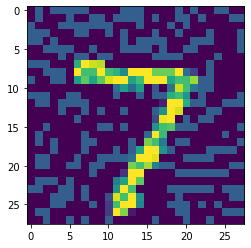

[('number 7', 0.9999994)]

with the previous model we had:
[('number 2', 0.6245198), ('number 7', 0.37546432)]


In [170]:
#the adversarial example from FGSM (unseen during training)
img_adv_test = x_test_adv3[0:1]
print("now we have:")
show_predict(img_adv_test, predict = True, pred_model = robust_mnist_model)

print("")
print("with the previous model we had:")
show_predict(img_adv_test, predict = True, pred_model = mnist_model, show_img = False)

## But how about generating new adversarial examples for this new model?

In [183]:
# Generating adversarial test examples
#wrapping our new keras model for the attacking algorithm
wrapped_classifier_new = KerasClassifier(model = robust_mnist_model, use_logits = False)

attack_new = FastGradientMethod(classifier = wrapped_classifier_new, eps = 0.30, targeted = False)
X_test_adv_new = attack_new.generate(x = X_test)

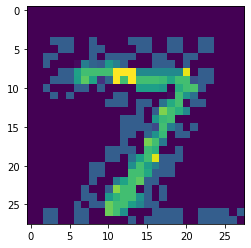

[('number 7', 0.9611659)]


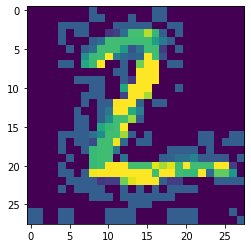

[('number 1', 0.39863703), ('number 2', 0.60136276)]


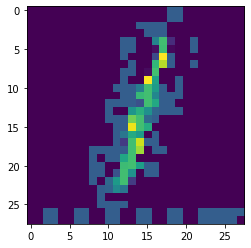

[('number 1', 0.9675312)]


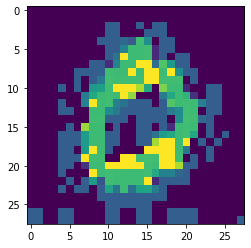

[('number 0', 0.36473185), ('number 2', 0.27199835), ('number 3', 0.080182865), ('number 5', 0.08845024), ('number 7', 0.055444825), ('number 9', 0.13629407)]


In [184]:
#plotting 4 of the resulting adversarial images

for i in range(4):
    img_adv_new = X_test_adv_new[i:i+1]
    show_predict(img_adv_new, predict = True, pred_model = robust_mnist_model)

# Adversarial samples in training: summary

**pros:**
- easy to implement
- can keep the model structure
- can learn to ignore many new types of noise
- can combine samples from different attacks

**cons:**
- very different attack types may still succeed
- needed amount of adversarial training data is unclear
- when overdone, may hurt identification of normal samples
- actual safety of the model is hard to measure

## Homework

Instead of training the model only once with adversarial samples generated for a single model, do the following:

1. Train the initial model using the original training data (potentially with a bit of adversary samples already)
2. Use an attacker to generate adversarial samples for this initial model
3. Train the model further to also include these new samples (mix them with some original data)
4. Repeat 2 & 3 in a loop until the performance on the original test set starts dropping too much

5. Test the final model using new adversarial samples, preferably from alternative attack strategies

*Bonus:* on step 2 alternate different attack strategies

*Future tip:* a similar procedure can be done if you train a model alongside a generator, like [here](https://github.com/IBM/adversarial-robustness-toolbox/blob/master/examples/adversarial_training_data_augmentation.py)

# Advanced defenses & further reading

## Mixup ([Smooth decision boundaries](https://arxiv.org/abs/1710.09412))

<img src="images/mixup.png" width="600" style="display: block;margin-left: auto;margin-right: auto;"/>

# Conclusions and Extra Tips

- Existent NNs are surprisingly vulnerable!
- The domain of adversarial attacks and defenses against them is quite new, therefore there are new methods developed on both sides as we speak
- Having a model that is robust to various input forms and perturbations is generally a good idea: it can also help us detect regular unusual cases
- Going all in with just one defense approach is usually risky
- Every method comes with its own trade-offs that we need to be aware of
- Try to "hack" your own NNs and see where they are vulnerable
- Visualize and test the decision boundaries 
- Flag unusual inputs
- Do not let the algorithm make most costly mistakes in ambiguous situations

## What's next?

There is much more to Deep Learning than what we covered today! If you find this a relevant and interesting subject - it is definitely a good idea to learn more about the topic. This notebook contains a number of references to more other techniques - which could be a good next step.

**GoDataDriven** also offers in-depth [Deep Learning Trainings](https://xebia.com/academy/en/training/deep-learning) as well as a number of [other trainings](https://xebia.com/academy/en/data-science) that could boost your skills and career! The **next Deep Learning is in 2 weeks**

In these unusual times we were quite successfully at moving online, and Xebia now offers a [33% discount](https://xebia.com/academy/en/virtual33) for those interested!

If you doubt which training would suit you best, our [expert skills accelerator Koen van Riemsdijk](https://godatadriven.com/team/koen-vanriemsdijk/) is always happy to chat with you and give his advice!

**See you next time!**

<a href="https://xebia.com/academy/en/data-science">
<img src="https://godatadriven.com/wp-content/uploads/2019/09/GoDataDriven-FeaturedImage4a.jpg" style="width: 600px;" href/>
 </a>


# Thank you for your attention!

<img src="images/meme.png" width="700" style="display: block;margin-left: auto;margin-right: auto;"/>